# Assignment 4 - RNN for Stock Price Prediction

by Bryan Carr

26 July 2022

for USD's AAI 511: Neural Networks and Deep Learning



In this assignment, we will build a recurrent neural network (RNN) to track and predict the price of Meta's stock (the parent company of Facebook and Instagram). The data is taken from Yahoo Finance, over a period of 1 Jan 2017 to present. We will use the Closing stock price, as it is after the majority of the trading day's activity has happened.

## 4.1 - EDA and Data Preparation

First we will import some basic libraries. Then mount the Google Drive and read in the data file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read in the data
meta_df = pd.read_csv('/content/drive/My Drive/AAI511/META.csv', parse_dates=['Date'])

In [4]:
meta_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,116.029999,117.839996,115.510002,116.860001,116.860001,20663900
1,2017-01-04,117.550003,119.660004,117.290001,118.690002,118.690002,19630900
2,2017-01-05,118.860001,120.949997,118.320000,120.669998,120.669998,19492200
3,2017-01-06,120.980003,123.879997,120.029999,123.410004,123.410004,28545300
4,2017-01-09,123.550003,125.430000,123.040001,124.900002,124.900002,22880400
...,...,...,...,...,...,...,...
1394,2022-07-19,170.369995,176.490005,169.509995,175.779999,175.779999,25933700
1395,2022-07-20,177.490005,183.600006,176.699997,183.089996,183.089996,24784300
1396,2022-07-21,180.630005,183.850006,178.869995,183.169998,183.169998,27195800
1397,2022-07-22,173.070007,175.600006,168.410004,169.270004,169.270004,42526700


In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1399 non-null   datetime64[ns]
 1   Open       1399 non-null   float64       
 2   High       1399 non-null   float64       
 3   Low        1399 non-null   float64       
 4   Close      1399 non-null   float64       
 5   Adj Close  1399 non-null   float64       
 6   Volume     1399 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 76.6 KB


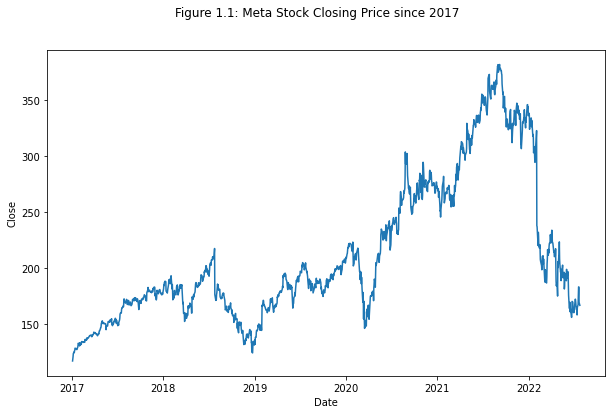

In [6]:
# Plot the Close Price by Date

fig = plt.figure(figsize=(10,6))

sns.lineplot(data=meta_df,
                x='Date',
                y='Close')

fig.suptitle('Figure 1.1: Meta Stock Closing Price since 2017')
plt.show()

The .info shows us no Null values to be concerned with.

We will use the data from 2017 through 2021 as our Training set, with the data in 2022 as our Test set, as in the examples given. Note that the steep crash in price around the start of 2022 may cause issues - we will see. It might be worth trying to run the data through backwards in time, as the 2017 data looks more stable.

### 4.1.1 Data Pre-Processing

We will scale our data with a Min-Max scaler, to put it all in the range of 0 to 1. Note that this may be considered information leakage from the test set to training, because we are scaling before splitting. However, since scaling is mainly done to facilitate the modelling, I consider it OK. We are also only scaling on the max and min, not on any calculated features (e.g. mean or stdev), which would be more serious leakage. Lastly, the scaling is done largely to help prevent any errors that might be caused by negative entries, so scaling the entire range helps achieve that in one simple step.


In [7]:
# Create a cutoff date for the Train and Test sets
# Find the Index value -- we will need the Index to split our scaled data

cutoff_date_index = meta_df.loc[meta_df['Date'] > '2022-01-01'].index[0]

In [11]:
# Import the Min_Max_Scaler and apply it to both sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_df = scaler.fit_transform(meta_df['Close'].array.reshape(-1,1))

In [12]:
scaled_df

array([[0.        ],
       [0.00689734],
       [0.01436001],
       ...,
       [0.24992462],
       [0.19753507],
       [0.18766016]])

## 4.2 - Building an Initial Model, Including Data Shaping

Next we will want to build our first model, as in the example. To do so we will need to shape our data so it is appropriate for 60-entry training batches. I will build a Train-Test Split into the Shaper, to make the process repeatable for different data shapes down the road, and to facilitate the pre-processing of both train and test data in one step.


## 4.2.1 - Shaping our Data for the LTSM

In [14]:
# Shape Data Function
#
# Purpose: to filter & reshape our input Data into Training and Testing data,
#           Appropriately reshaped for our LTSM models
#
# Inputs: Num_Days: integer; number of days to go back to train with
#         Data_DF: DataFrame; set of all data points
#               DF should include all Training, then all Testing data
#         Cutoff: Index value of cutoff point at the start of Test data
#
# Outputs: X_Train: Array, 3-dimensions: Number of training sets of length Num_Days
#          Y_Train: Array, 1-dim: Next stock price after training set


def shape_data(num_days, data_df, cutoff):
  x_trn = []
  y_trn = []

  # Filter off Training dataset: Up to the Cutoff range
  for i in range (num_days, cutoff):
     x_trn.append(data_df[i-num_days : i, 0])
     y_trn.append(data_df[i,0])
  
  x_trn, y_trn = np.array(x_trn), np.array(y_trn)

  #Reshape into 3-D array for LTSMs
  # shape[0] rows, each with num_days entries, in 1-size arrays
  x_trn = np.reshape(x_trn, (x_trn.shape[0], x_trn.shape[1], 1) )


  #Initialize/reset Test set vars
  x_tst = []
  y_tst = []

  # Filter off Test dataset: After the Cutoff
  for i in range (cutoff, data_df.shape[0]):
    x_tst.append(data_df[i-num_days : i, 0])
    y_tst.append(data_df[i,0])

  # Convert to Arrays
  x_tst, y_tst = np.array(x_tst), np.array(y_tst)

  # Reshape X to 3 dims for LTSM -- dims Length x Num_Days x 1
  x_tst = np.reshape(x_tst, (x_tst.shape[0], x_trn.shape[1], 1) )

  return(x_trn, y_trn, x_tst, y_tst)

In [15]:
# Create datasets with 60 day length
x_train = []
y_train = []

x_train, y_train, x_test, y_test = shape_data(60, scaled_df, cutoff_date_index)

In [16]:
x_train.shape

(1199, 60, 1)

In [17]:
y_train.shape

(1199,)

In [18]:
x_test.shape

(140, 60, 1)

In [19]:
y_test.shape

(140,)

## 4.2.1: Building the LTSM Model

Next we will import the key libraries to build our LTSM, then proceed with assembling the model. I will build only 1 LTSM layer initially, for simplicity.

We also need to set our random seeds -- this is a good time, before any training gets started.

I will also create an Early Stopping callback

In [20]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping

In [21]:
# Set Random Seeds

np.random.seed(25)
tf.random.set_seed(25)

In [22]:
# Create our Early Stopping Callback
# We will stop at the Minimum, with a 20-epoch patience tolerance added, in case we are stopping on a local minima and could do better

es = EarlyStopping(monitor='loss', mode='min', patience=20, verbose=1)

In [23]:
# Create out first, simple Model

model1 = Sequential()

# Add first LTSM layer
model1.add(LSTM(units=60, input_shape = (x_train.shape[1], 1), name='lstm1') )
model1.add(Dropout(0.2))

# Add output Dense layer
model1.add(Dense(units=1, name='output'))

In [24]:
# Compile the model

model1.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Plot a summary of the model

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 60)                14880     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 output (Dense)              (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Fit the Model

history1 = model1.fit(x_train, y_train,
                      batch_size=20,
                      epochs=300,
                      callbacks=es,
                      verbose=1)

Epoch 1/300
60/60 [==============================] - 7s 9ms/step - loss: 0.0174
Epoch 2/300
60/60 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 3/300
60/60 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 4/300
60/60 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 5/300
60/60 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 6/300
60/60 [==============================] - 1s 8ms/step - loss: 0.0026
Epoch 7/300
60/60 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8/300
60/60 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 9/300
60/60 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 10/300
60/60 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 11/300
60/60 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 12/300
60/60 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 13/300
60/60 [===============

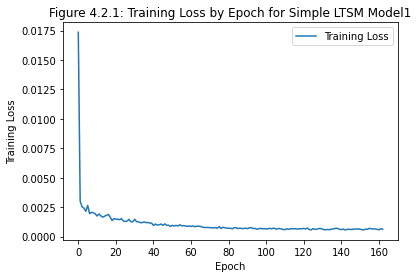

In [28]:
plt.plot(history1.history['loss'])
plt.title('Figure 4.2.1.1: Training Loss by Epoch for Simple LTSM Model1')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

## 4.2.2: Creating Predictions

To generate predictions, we will use the test datasets. Recall that x_test was built with data from the end of the training dataset, so that every point in y_test has the correct number of time interval entries from x_test preceeding it (60 entries in this first model).

We will begin with making some predictions based on X_Test. Then we will plot them against Y_Test. Finally we will compute the R-Squared value for best fit, as a measure of our regressor's quality.

In [31]:
model1_pred = model1.predict(x_test)

In [33]:
model1_pred.shape

(140, 1)

In [34]:
y_test.shape

(140,)

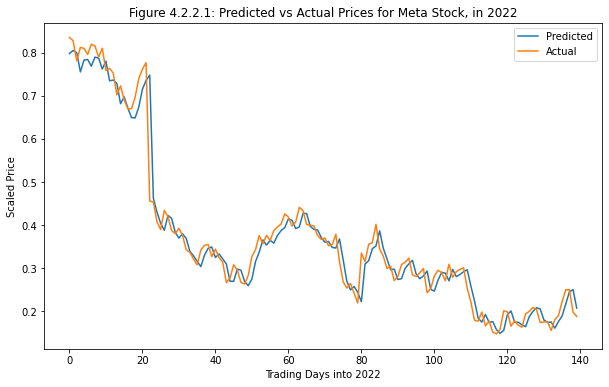

In [42]:
plt.figure(figsize=(10,6))
plt.plot(model1_pred)
plt.plot(y_test)

plt.legend(['Predicted', 'Actual'])
plt.title('Figure 4.2.2.1: Predicted vs Actual Prices for Meta Stock, in 2022')
plt.xlabel('Trading Days into 2022')
plt.ylabel('Scaled Price')
plt.show()

In [36]:
from sklearn.metrics import r2_score

In [44]:
# Calculate the R^2 score
# Naming this Model 60 for 60 Units wide

model60_r2 = r2_score(y_test, model1_pred)
model60_r2

0.9600413445991592

We can see there is a very strong predictive performance, though with a slight delay. This indicates that the model is able to react to current performance extremely well, but not effective at predicting future price. The R^2 score of 0.96 is quite strong, though demonstrates some clear room for improvement.

I will aim to explore several additional models: a smaller one (with fewer units); a wider one with more units; and a deeper one (similar to the example).

## 4.3: Creating a Narrow Model

I will aim to create a narrow model, with fewer units (down from the 60 used in the initial model, which I picked coincidentally as it mirrors the interval size).

In [45]:
# Create our Second, simpler Model
# We will use half as many units

model2 = Sequential()

# Add first LTSM layer
model2.add(LSTM(units=30, input_shape = (x_train.shape[1], 1), name='lstm1') )
model2.add(Dropout(0.2))

# Add output Dense layer
model2.add(Dense(units=1, name='output'))

In [46]:
# Compile the model

model2.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
# Plot a summary of the model

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 30)                3840      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 output (Dense)              (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
# Fit the Model

history2 = model2.fit(x_train, y_train,
                      batch_size=20,
                      epochs=300,
                      callbacks=es,
                      verbose=1)

Epoch 1/300
60/60 [==============================] - 3s 8ms/step - loss: 0.0183
Epoch 2/300
60/60 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 3/300
60/60 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 4/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 5/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 6/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 7/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 8/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 9/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 10/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 11/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 12/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 13/300
60/60 [=================

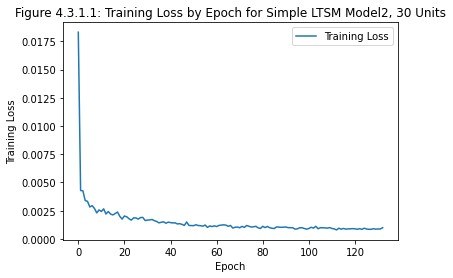

In [49]:
plt.plot(history2.history['loss'])
plt.title('Figure 4.3.1.1: Training Loss by Epoch for Simple LTSM Model2, 30 Units')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [50]:
# Create Predictions
model2_pred = model2.predict(x_test)

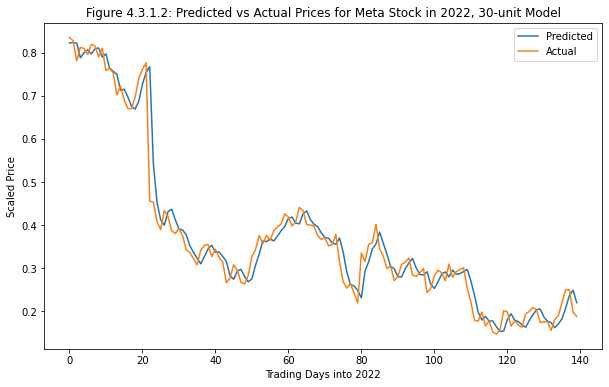

In [51]:
plt.figure(figsize=(10,6))
plt.plot(model2_pred)
plt.plot(y_test)

plt.legend(['Predicted', 'Actual'])
plt.title('Figure 4.3.1.2: Predicted vs Actual Prices for Meta Stock in 2022, 30-unit Model')
plt.xlabel('Trading Days into 2022')
plt.ylabel('Scaled Price')
plt.show()

In [52]:
# Calculate the R^2 score
# Naming this Model 60 for 60 Units wide

model30_r2 = r2_score(y_test, model2_pred)
model30_r2

0.9561485755563273

We can see we have nearly as good a prediction (and better predictions early on, before the crash around T=20). The R^2 value for this second model is slightly lower at 0.956, compared to 0.960. Performance looks worse later on around T=100 and T=120, where fluctuations in the actual price are not caught as quickly.

However, we see similar behaviour where the prediction appears to lag the actual value by about a day. predicting yesterday's price is not very useful in reality.

## 4.3: Creating a Wider Model

Let's now try a wider model, with 120 units - double the initial model's.

I will also create a master function to compile, fit and plot our models, as that is repetitive work.

In [1]:
# Model_and_Plot function
#
# Purpose: To consolidate repetitive modelling and plotting functions, which will facilitate additional experimentation
#     Compiles the model
#     Fits the model to the given Training data
#     Prints the architecture Summary
#     Plots the training progress based on Epoch
#     Makes Predictions
#     Plots the predictions vs actual
#     Calculates and returns the R2 value
#
# Inputs: Model - the LTSM model to be trained
#     X_Trn, X_Tst: the training and testing data. Must be in 3-dimensional LTSM format
#     Y_Trn, Y_Tst: The training and testing actual values.
#
# Outputs: Returns the R2 value
#     Prints other results and visualizations as listed above
#

def model_and_plot(model, x_trn, y_trn, x_tst, y_tst):
  # First compile the given model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Next fit the model
  history = model.fit(x_trn, y_trn,
                      batch_size=20,
                      epochs=300,
                      callbacks=es,
                      verbose=1)
  
  # Next print a summary of the model
  print("Summary of present Model's architecture:")
  print(model.summary())

  # Now plot the Training performance of the current model
  plt.plot(history.history['loss'])
  plt.title('Training Loss by Epoch for present Model')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.legend(['Training Loss'], loc='upper right')
  plt.show()

  # Now make predictions
  pred = model.predict(x_tst)

  # Now plot the performance
  plt.figure(figsize=(10,6))
  plt.plot(pred)
  plt.plot(y_tst)

  plt.legend(['Predicted', 'Actual'])
  plt.title('Predicted vs Actual Prices for Meta Stock in 2022 (Scaled; current Model)')
  plt.xlabel('Trading Days into 2022')
  plt.ylabel('Scaled Price')
  plt.show()

  # Lastly, calculate the R^2 value
  r2 = r2_score(y_tst, pred)
  print('R^2 score is: ' + str(r2))

  return(r2)



In [63]:
# Create our Third model, with double the units (120)

model3 = Sequential()

# Add first LTSM layer
model3.add(LSTM(units=120, input_shape = (x_train.shape[1], 1), name='lstm1') )
model3.add(Dropout(0.2))

# Add output Dense layer
model3.add(Dense(units=1, name='output'))

Epoch 1/300
60/60 [==============================] - 2s 7ms/step - loss: 0.0186
Epoch 2/300
60/60 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 4/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 6/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 7/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 9/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 10/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 11/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 12/300
60/60 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/300
60/60 [=================

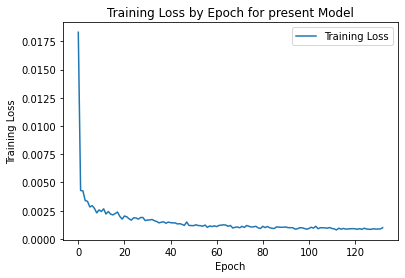

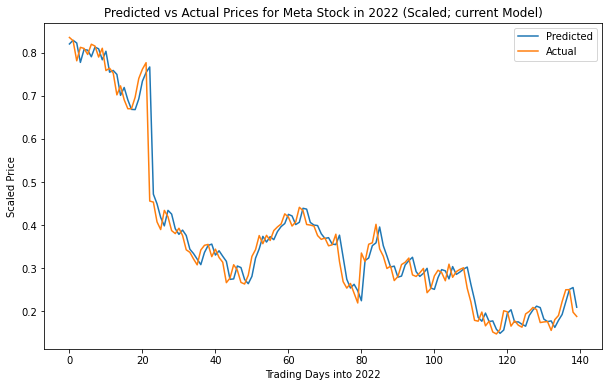

R^2 score is: 0.9592548568994179


0.9592548568994179

In [64]:
model_and_plot(model3, x_train, y_train, x_test, y_test)

We can see similar performance to the previous iteration, with lower R^2 value compared to the initial attempt at units=60, and similar delay in prediction.

## 4.4: Creating a Deeper Model

60 units worked well for us initially. Let's try a deeper model, as in the example. I don't want to go three layers deep, only two, as the example model looked worse off than our current predictions -- I think the additional layers will add more delay and smooth predictions further.

In [82]:
# Create our Fourth model, with double the units (120), in two layers

model4 = Sequential()

# Add first LSTM layer
model4.add(LSTM(units=60, return_sequences=True, input_shape = (x_train.shape[1], 1), name='lstm1') )
model4.add(Dropout(0.2))

# Add a second LSTM layer
model4.add(LSTM(units=60, input_shape = (x_train.shape[1], 1), name='lstm2') )
model4.add(Dropout(0.2))

# Add output Dense layer
model4.add(Dense(units=1, name='output'))

Epoch 1/300
60/60 [==============================] - 3s 9ms/step - loss: 7.3542e-04
Epoch 2/300
60/60 [==============================] - 0s 8ms/step - loss: 8.0699e-04
Epoch 3/300
60/60 [==============================] - 0s 8ms/step - loss: 7.2013e-04
Epoch 4/300
60/60 [==============================] - 0s 8ms/step - loss: 7.4079e-04
Epoch 5/300
60/60 [==============================] - 0s 8ms/step - loss: 7.4383e-04
Epoch 6/300
60/60 [==============================] - 0s 8ms/step - loss: 7.3693e-04
Epoch 7/300
60/60 [==============================] - 0s 8ms/step - loss: 8.3237e-04
Epoch 8/300
60/60 [==============================] - 0s 8ms/step - loss: 7.7261e-04
Epoch 9/300
60/60 [==============================] - 0s 8ms/step - loss: 7.2348e-04
Epoch 10/300
60/60 [==============================] - 0s 8ms/step - loss: 7.7845e-04
Epoch 11/300
60/60 [==============================] - 0s 8ms/step - loss: 8.1286e-04
Epoch 12/300
60/60 [==============================] - 0s 8ms/step - loss: 

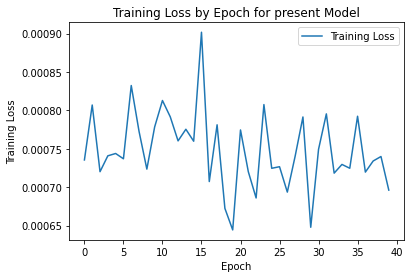

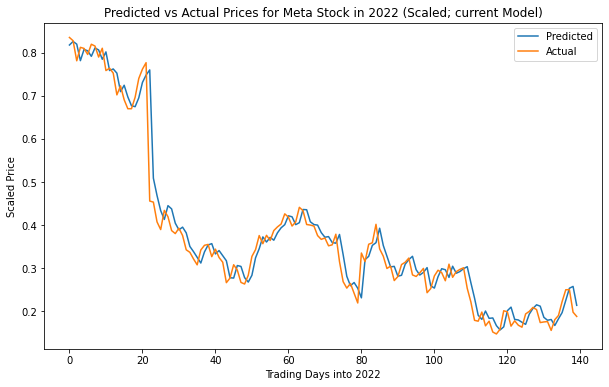

R^2 score is: 0.9582494884609797


0.9582494884609797

In [84]:
model_and_plot(model4, x_train, y_train, x_test, y_test)

This model is performing quite similarly to the previous ones -- the additional layer has not improved performance, with R^2 value of 0.958.

## 4.5: Conclusions

We were fortunate to stumble upon a good model right off the bat. From reading some literature and guides, I suspected that 1 layer of LTSM depth should be sufficient, and was proven right. The initial model with 60 units gave us the best performance, with R^2 of 0.960. Other models (narrower, wider, and deeper) all had slightly lower R^2 -- though only very slightly. This indicates that 1 layer is a good compute compromise for this problem.

Unfortunately, my Google Colab GPU access has run out, putting a premature end to the experimentation this week. Otherwise I would have liked to experiment with number of units around 60 (eg 40, 50, 70, 80); different batch sizes; and different data lengths around 60 days (40, 50, 70, 80 days).